# Script to read and process netCDF data

## Import libraries

In [1]:
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import xarray as xr
import rioxarray
import dask
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point
import pickle
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.ticker import FuncFormatter, FixedLocator

## Import shapefile and netCDF data

In [2]:
# Enable Dask's automatic parallelization
dask.config.set(scheduler='threads')

<Axes: >

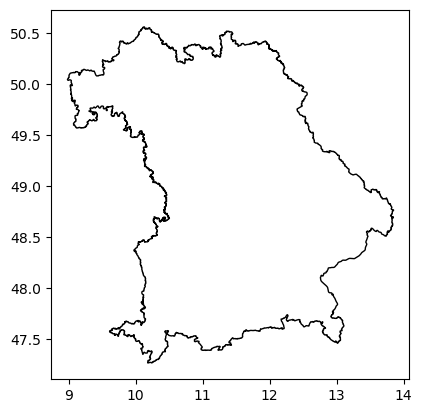

In [3]:
# Load the shapefile
shapefile_path = r"C:\Users\project\bavaria_outline.shp"
bavaria_polygon = gpd.read_file(shapefile_path)
bavaria_polygon = bavaria_polygon.to_crs('EPSG:4326')

# check the shapefile
bavaria_polygon.plot(color='white', edgecolor='black')

In [4]:
# Open the netCDF file

data = xr.open_dataset('monthly_prec_sum.nc').chunk({'variable': 10, 'lat': 1000, 'lon': 1000})

In [5]:
data

<xarray.Dataset> Size: 52GB
Dimensions:   (variable: 12, lat: 13920, lon: 39000)
Coordinates:
  * lat       (lat) float64 111kB -56.0 -55.99 -55.98 ... 59.98 59.99 60.0
  * lon       (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Data variables:
    crs       (variable) |S1 12B dask.array<chunksize=(10,), meta=np.ndarray>
    prec_sum  (variable, lat, lon) float64 52GB dask.array<chunksize=(10, 1000, 1000), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Millimeter [mm]
    Source:              WorldClim, Hijmans et al. (2005)
    Dataset:             Upstream precipitation sum
    scale_factor:        1
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

In [6]:
data['prec_sum']

<xarray.DataArray 'prec_sum' (variable: 12, lat: 13920, lon: 39000)> Size: 52GB
dask.array<xarray-prec_sum, shape=(12, 13920, 39000), dtype=float64, chunksize=(10, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 111kB -56.0 -55.99 -55.98 -55.97 ... 59.98 59.99 60.0
  * lon      (lon) float64 312kB -145.0 -145.0 -145.0 ... 180.0 180.0 180.0
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 3.458339e+08 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   3.458339e+08 6.916678e+08 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   6.916678e+08 1.037502e+09 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   1.037502e+09 1.383336e+09 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   1.383336e+09 1.729170e+09 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                monthly_prec_sum
    units:                    Millimeter [mm]

## Clip the netCDF data

In [7]:
# Convert the dataset to use rioxarray for geospatial operations, setting the CRS
data_rio = data.rio.write_crs("EPSG:4326")

In [8]:
# Crop the data using the region of interest, applying the shapefile's geometry
clipped_data = data_rio.rio.clip(bavaria_polygon.geometry.apply(mapping), bavaria_polygon.crs, drop=True)

In [9]:
clipped_data

<xarray.Dataset> Size: 22MB
Dimensions:   (lat: 396, lon: 584, variable: 12)
Coordinates:
  * lat       (lat) float64 3kB 47.27 47.28 47.29 47.3 ... 50.55 50.55 50.56
  * lon       (lon) float64 5kB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
    crs       int32 4B 0
Dimensions without coordinates: variable
Data variables:
    prec_sum  (variable, lat, lon) float64 22MB dask.array<chunksize=(10, 396, 523), meta=np.ndarray>
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 1.10.0, released 2013/04/24
    units:               Millimeter [mm]
    Source:              WorldClim, Hijmans et al. (2005)
    Dataset:             Upstream precipitation sum
    scale_factor:        1
    Author:              sami.domisch@yale.edu & giuseppe.amatulli@gmail.com
    Software:            GRASS 7 using the add-ons r.stream.watersheds & r.st...

## Convert xarray to dataframes

In [10]:
# Flatten the data to check the dimensions required for the dataframe

flat_data = clipped_data['prec_sum'].stack(space=['lat', 'lon'])
flat_data

<xarray.DataArray 'prec_sum' (variable: 12, space: 231264)> Size: 22MB
dask.array<reshape, shape=(12, 231264), dtype=float64, chunksize=(10, 115632), chunktype=numpy.ndarray>
Coordinates:
    crs      int32 4B 0
  * space    (space) object 2MB MultiIndex
  * lat      (space) float64 2MB 47.27 47.27 47.27 47.27 ... 50.56 50.56 50.56
  * lon      (space) float64 2MB 8.979 8.988 8.996 9.004 ... 13.82 13.83 13.84
Dimensions without coordinates: variable
Attributes:
    COLOR_TABLE_RULE_RGB_0:   0.000000e+00 3.458339e+08 255 255 0 0 255 0
    COLOR_TABLE_RULE_RGB_1:   3.458339e+08 6.916678e+08 0 255 0 0 255 255
    COLOR_TABLE_RULE_RGB_2:   6.916678e+08 1.037502e+09 0 255 255 0 0 255
    COLOR_TABLE_RULE_RGB_3:   1.037502e+09 1.383336e+09 0 0 255 255 0 255
    COLOR_TABLE_RULE_RGB_4:   1.383336e+09 1.729170e+09 255 0 255 255 0 0
    COLOR_TABLE_RULES_COUNT:  5
    Generated_with:           GRASS GIS 7.0.0beta1
    grid_mapping:             crs
    long_name:                monthly_prec_sum
    units:                    Millimeter [mm]

In [11]:
# Prepare the dataframes

# Extract variable
prec_sum = clipped_data['prec_sum']

# Convert the DataArray to a pandas DataFrame
df = prec_sum.to_dataframe(name='value').reset_index()
display(df)


#pd.options.display.max_rows = 1000
#pd.options.display.min_rows = 500

# Pivot the DataFrame to have bands as columns
df_pivoted = df.pivot(index=['lat', 'lon'], columns='variable', values='value').reset_index()
display(df_pivoted)

#remove nan values
df_filtered = df_pivoted.dropna(axis=0, how='any').reset_index()

display(df_filtered)


,variable,lat,lon,crs,value
0,0,47.270833,8.979167,0,NaN
1,0,47.270833,8.987500,0,NaN
2,0,47.270833,8.995833,0,NaN
3,0,47.270833,9.004167,0,NaN
4,0,47.270833,9.012500,0,NaN
...,...,...,...,...,...
2775163,11,50.562500,13.804167,0,NaN
2775164,11,50.562500,13.812500,0,NaN
2775165,11,50.562500,13.820833,0,NaN
2775166,11,50.562500,13.829167,0,NaN


variable,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11
0,47.270833,8.979167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,47.270833,8.987500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,47.270833,8.995833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,47.270833,9.004167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,47.270833,9.012500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231259,50.562500,13.804167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231260,50.562500,13.812500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231261,50.562500,13.820833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
231262,50.562500,13.829167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


variable,index,lat,lon,0,1,2,3,4,5,6,7,8,9,10,11
0,1902,47.295833,10.229167,2139.0,1950.0,2071.0,2422.0,3191.0,3583.0,4184.0,4150.0,2882.0,2111.0,2533.0,2287.0
1,2487,47.304167,10.237500,2347.0,2140.0,2272.0,2662.0,3521.0,3948.0,4614.0,4577.0,3178.0,2324.0,2786.0,2512.0
2,2488,47.304167,10.245833,2672.0,2439.0,2589.0,3044.0,4059.0,4540.0,5308.0,5270.0,3660.0,2670.0,3187.0,2869.0
3,3073,47.312500,10.254167,2875.0,2625.0,2787.0,3279.0,4388.0,4903.0,5734.0,5694.0,3953.0,2880.0,3436.0,3091.0
4,3074,47.312500,10.262500,3755.0,3428.0,3648.0,4275.0,5667.0,6338.0,7399.0,7332.0,5093.0,3727.0,4446.0,4029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16445,228480,50.529167,10.112500,2333.0,1659.0,2158.0,1990.0,2346.0,2853.0,2568.0,2370.0,2039.0,2262.0,2300.0,2714.0
16446,228481,50.529167,10.120833,2506.0,1801.0,2320.0,2158.0,2542.0,3104.0,2781.0,2575.0,2201.0,2451.0,2499.0,2933.0
16447,228482,50.529167,10.129167,2731.0,1987.0,2530.0,2377.0,2798.0,3434.0,3061.0,2845.0,2413.0,2698.0,2759.0,3218.0
16448,228484,50.529167,10.145833,4845.0,3620.0,4496.0,4300.0,5051.0,6259.0,5525.0,5167.0,4322.0,4876.0,5025.0,5790.0


In [12]:
df = df_filtered.drop(columns = ['index', 'lat', 'lon'])

In [13]:
prec_dat = df.to_numpy()

In [14]:
prec_dat

array([[2139., 1950., 2071., ..., 2111., 2533., 2287.],
       [2347., 2140., 2272., ..., 2324., 2786., 2512.],
       [2672., 2439., 2589., ..., 2670., 3187., 2869.],
       ...,
       [2731., 1987., 2530., ..., 2698., 2759., 3218.],
       [4845., 3620., 4496., ..., 4876., 5025., 5790.],
       [4516., 3346., 4186., ..., 4514., 4641., 5372.]])

In [15]:
prec_all = prec_dat.flatten()

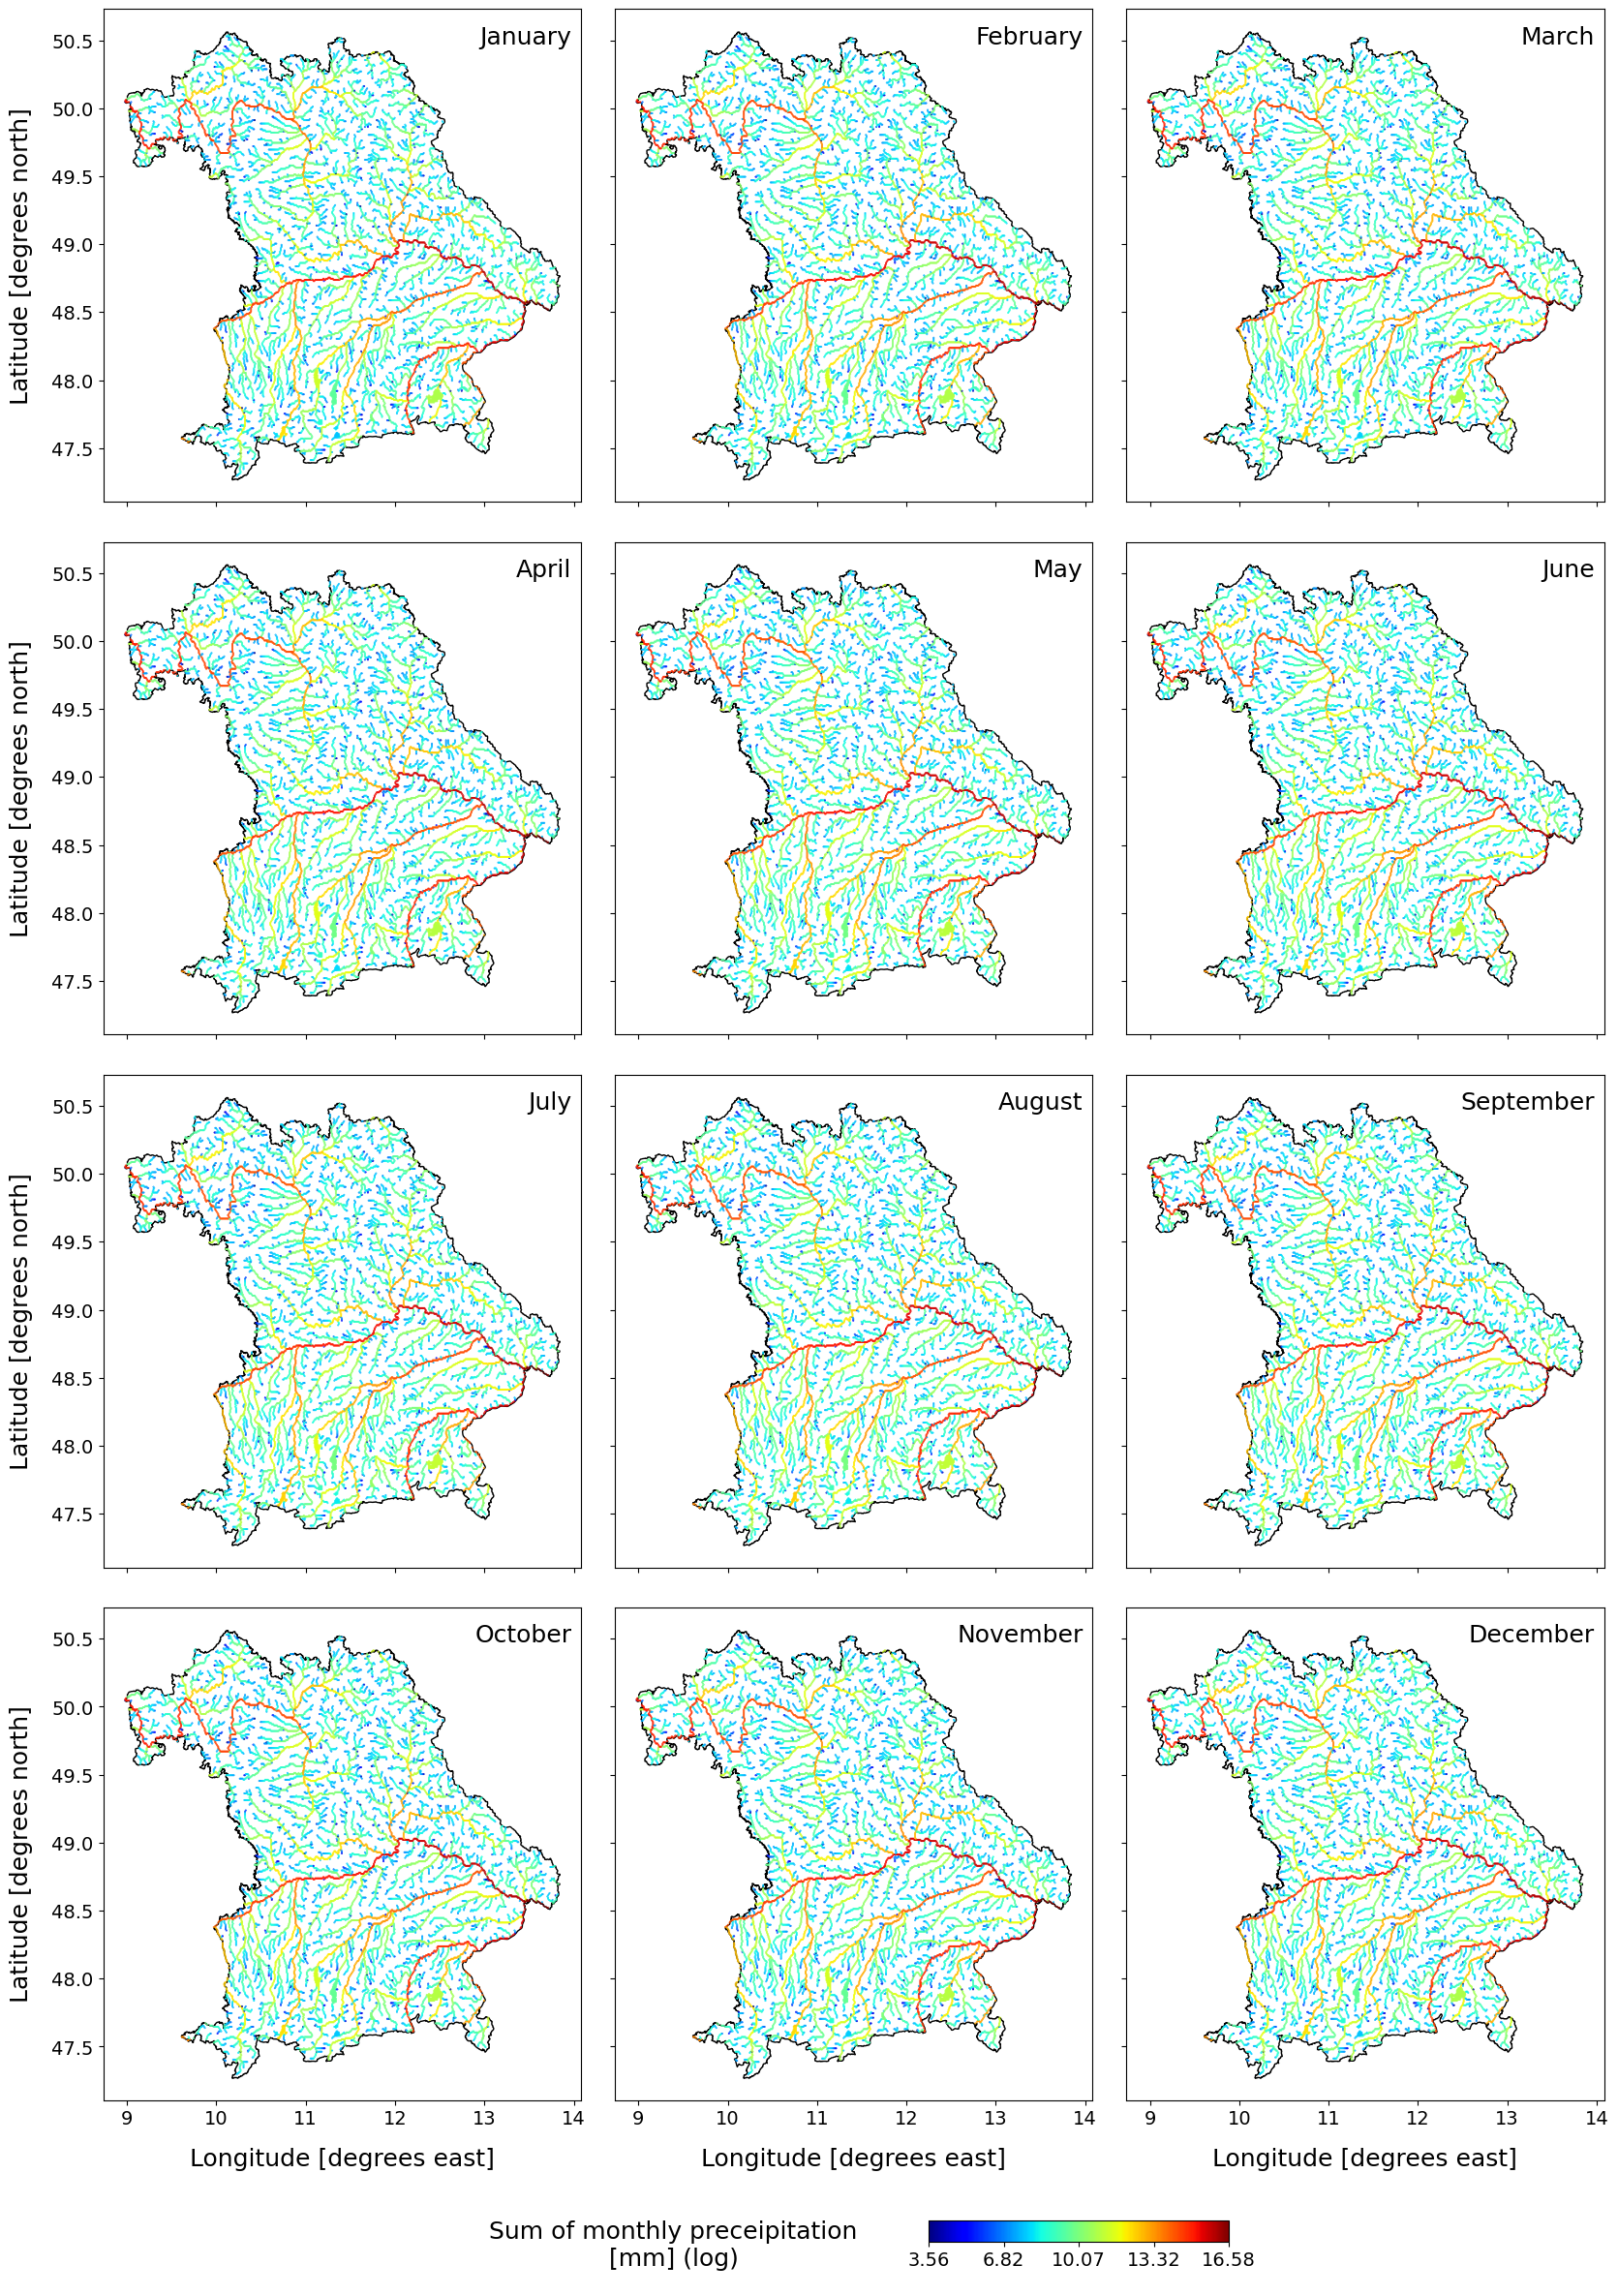

In [18]:
# Create subplots for all the months


row_dict = {0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 4, 13: 4, 14: 4}  # storing row indices for subplot in a dictionary
col_dict = {0: 0, 1: 1, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: 1, 8: 2, 9: 0, 10: 1, 11: 2, 12: 0, 13: 1, 14: 2}  # storing column indices for subplot in a dictionary
label_dict = {0: 'January', 1: 'February', 2: 'March', 3: 'April', 4: 'May', 5: 'June', 6: 'July', 7: 'August', 8: 'September', 9: 'October', 10: 'November', 11: 'December'}  # storing labels for subplot in a dictionary


fig = plt.figure(figsize=(20, 30))
grid = plt.GridSpec(5, 3, wspace = 0.07,hspace = 0.01, height_ratios=[10,10,10,10,2])

log_prec_min = min(np.log(prec_all))
log_prec_max = max(np.log(prec_all))
norm = plt.Normalize(vmin=log_prec_min, vmax=log_prec_max)

for i in range(13):
# If i is less than 12, then we plot the subplots for available data. If i is 12, we plot the last row of subplot grid and combine all 3 of its columns into a single row. 
# The colorbar and the size legend is then plotted in this last subplot and the borders are then removed.            
    if i < 12:    
        data_to_plot = np.log(df_filtered.iloc[:,i+3])
        ax = fig.add_subplot(grid[row_dict[i], col_dict[i]])
        bavaria_polygon.plot(ax=ax, color='white', edgecolor='black')
        sc = ax.scatter(df_filtered.iloc[:,2], df_filtered.iloc[:,1], c=norm(data_to_plot), cmap='jet', s=0.2)
        ax.text(0.98, 0.93, label_dict[i], transform = ax.transAxes, size = 18,ha='right')
        
        # only add x label for the last row of subplot (last row of the subplots with data. the actual last row is the one with color bar)
        if i in range(9,12):
            
            ax.set_xlabel('Longitude [degrees east]', fontsize = 18, labelpad = 14)

        
        # only add y label for the first column of subplot    
        if i in range(0,10,3):
            
            ax.set_ylabel('Latitude [degrees north]', fontsize = 18, labelpad = 14)

            
        if i not in range(9,12):
            ax.set_xticklabels([])
        
        
        if i not in range(0,10,3): 
            ax.set_yticklabels([])

        ax.tick_params(axis='x', labelsize=14)
        ax.tick_params(axis='y', labelsize=14)

    
    else:
        # plot the legend in the last row of subplot and combine all the columns
        cbar_ax = fig.add_subplot(grid[row_dict[i], :])
        
# manually adjust the positions of the subplots and the color bar
for ax in fig.axes[:-1]:
    pos = ax.get_position()
    ax.set_position([pos.x0, pos.y0 + 0.02, pos.width, pos.height])  
    
# insert the colorbar as an axes in the last row of subplot grid. this row was reserved for legend and has no data. 
cax = cbar_ax.inset_axes([0.55, 0.42,0.2, 0.2], transform=cbar_ax.transAxes) # [left, bottom, width, height] 
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'), cax=cax, orientation='horizontal')
min_cbar = round((np.log(prec_all.min())),2)
max_cbar = round((np.log(prec_all.max())),2)
ticks = np.linspace(np.log(prec_all.min()), np.log(prec_all.max()) , 5)
cbar.set_ticks(ticks) # the colorbar represents the normalized data by default so add ticks manually
cbar.set_ticklabels(np.around(np.linspace(min_cbar,max_cbar , 5), decimals = 2), fontsize=14 )
cbar_ax.text(0.38, 0.2, "Sum of monthly preceipitation\n [mm] (log) ", fontsize=18, ha="center", transform=cbar_ax.transAxes)

# remove boundaries of the last row of subplot grid
cbar_ax.set_xticks([])
cbar_ax.set_yticks([])
cbar_ax.spines['top'].set_visible(False)
cbar_ax.spines['right'].set_visible(False)
cbar_ax.spines['bottom'].set_visible(False)
cbar_ax.spines['left'].set_visible(False)

plt.savefig('stations_prec_sum_400dpi.jpg', format = 'jpg', bbox_inches = 'tight', dpi=400)

In [28]:
# save dataframe

# save the list variable
filepath = "df_filtered_prec_us_sum"
with open(filepath, 'wb') as file:
    pickle.dump(df_filtered, file)